### **Step 1**: Scrape the Wikipedia page.

In [1]:
import requests
from bs4 import BeautifulSoup

# Step 1: Fetch Wikipedia page
def fetch_wikipedia_page() -> BeautifulSoup:
    url: str = "https://en.wikipedia.org/wiki/List_of_highest-grossing_films"
    response: requests.Response = requests.get(url)
    soup: BeautifulSoup = BeautifulSoup(response.text, "html.parser")

    return soup

soup = fetch_wikipedia_page()

### **Step 2**: Extract relevant data available within that page.

In [2]:
import re

def extract_digits(value: str) -> str:
    """
    Extracts only numeric digits from a box office string.

    Args:
        value (str): The box office revenue string.

    Returns:
        str: A cleaned string containing only digits.
    """
    return re.sub(r'\D', '', value)  # Remove all non-digit characters

In [3]:
from typing import List, Dict, Any
from bs4.element import Tag

# Step 2: Extract data
def extract_main_data(soup: BeautifulSoup) -> List[Dict[str, Any]]:
    """
    Extracts key movie data from a Wikipedia table.

    Args:
        soup (BeautifulSoup): A BeautifulSoup object containing the parsed HTML.

    Returns:
        List[Dict[str, Any]]: A list of dictionaries, each containing movie details:
            - "title" (str): The movie title.
            - "release_year" (int): The year the movie was released.
            - "box_office" (int): The box office revenue as a cleaned string.
            - "film_url" (str): The Wikipedia URL of the film.
    """
    table: Tag = soup.find("table", {"class": "wikitable"})  # Locate the main table

    data: List[Dict[str, Any]] = []
    base_url: str = "https://en.wikipedia.org"

    for row in table.find_all("tr")[1:]:  # Skip header row
        columns: List[Tag] = row.find_all(["th", "td"])  # Extract table cells
        
        # Extract movie title and link
        title_tag: Tag = columns[2].find("a")
        title: str = title_tag.text.strip() if title_tag else columns[2].text.strip()
        film_url: str = base_url + title_tag["href"].replace(' ', '_') if title_tag else None

        # Extract release year
        release_year: int = int(columns[4].text.strip())

        # Extract and clean box office revenue (remove "$" and ",")
        box_office: int = int(extract_digits(columns[3].text.strip().replace("$", "").replace(",", "")))
        
        # Store extracted data
        data.append({
            "title": title,
            "release_year": release_year,
            "box_office": box_office,
            "film_url": film_url
        })

    return data

data: List[Dict[str, Any]] = extract_main_data(soup)
data[:3]

[{'title': 'Avatar',
  'release_year': 2009,
  'box_office': 2923706026,
  'film_url': 'https://en.wikipedia.org/wiki/Avatar_(2009_film)'},
 {'title': 'Avengers: Endgame',
  'release_year': 2019,
  'box_office': 2797501328,
  'film_url': 'https://en.wikipedia.org/wiki/Avengers:_Endgame'},
 {'title': 'Avatar: The Way of Water',
  'release_year': 2022,
  'box_office': 2320250281,
  'film_url': 'https://en.wikipedia.org/wiki/Avatar:_The_Way_of_Water'}]

### **Step 3**: Extract additional information (directors, countries, production companies)

In [4]:
from typing import Optional

def extract_production_companies(soup: BeautifulSoup) -> List[str]:
    """
    Extracts the list of production companies from a Wikipedia infobox.

    Args:
        soup (BeautifulSoup): A BeautifulSoup object containing the parsed HTML.

    Returns:
        List[str]: A list of production company names.
    """
    production_element: Optional[Tag] = None

    # Search for the "Production company" or similar label in the infobox
    for th in soup.find_all("th", class_="infobox-label"):
        if th.find("div"):  # Companies are wrapped in a <div>
            if th.get_text().strip().startswith("Productioncompan"):  # Handles variations like "Production company"
                production_element = th
                break

    if production_element is None:
        return []  # Return an empty list if no production company section is found

    # Find the corresponding <td> element that contains the company names
    production_td: Optional[Tag] = production_element.find_next_sibling("td")

    if production_td is None:
        return []  # Handle cases where <td> is missing

    # Extract production companies by filtering only valid Wikipedia links
    companies: List[str] = [
        a.text.strip() for a in production_td.find_all("a")
        if a.has_attr("href") and a["href"].startswith("/wiki/")
    ]

    return companies

# companies = extract_production_companies(soup)
# print(companies)

In [5]:
import re

def clear_and_split_text(text: str) -> List[str]:
    """
    Cleans and splits a text string by removing Wikipedia-style references 
    (e.g., [1], [2]) and excessive newlines.

    Args:
        text (str): The input text to clean and split.

    Returns:
        List[str]: A list of cleaned substrings split by newline characters.
    """
    # Remove Wikipedia-style references like [1], [2], etc.
    text = re.sub(r'\[\d+\]', '\n', text)

    # Replace multiple consecutive newlines (\n+) with a single newline
    text = re.sub(r'\n+', '\n', text).strip()

    # Split text into a list using newline as a separator
    return text.split('\n')

# cleaned_list = clear_and_split_text("United States[2]\nUnited Kingdom[3]\n\nCanada[4]")
# print(cleaned_list)

In [6]:
from time import sleep
from random import uniform
from tqdm import tqdm


def fetch_film_details(film: Dict[str, Any]) -> Dict[str, Any]:
    """
    Fetches additional details (directors, countries, production companies) 
    from an individual Wikipedia film page.

    Args:
        film (Dict[str, Any]): A dictionary containing basic film details, 
                               including a 'film_url' key.

    Returns:
        Dict[str, Any]: The updated film dictionary with extracted details.
    """
    if not film.get("film_url"):
        return film  # Skip if no Wikipedia URL is available

    # Send request to fetch the Wikipedia page
    response: requests.Response = requests.get(film["film_url"])
    soup: BeautifulSoup = BeautifulSoup(response.text, "html.parser")

    # Extract directors
    director_element: Tag = soup.find("th", string="Directed by")
    if director_element:
        directors_raw: str = director_element.find_next_sibling("td").text.strip()
        film["directors"] = clear_and_split_text(directors_raw)

    # Extract countries of origin
    country_element: Tag = soup.find("th", string=lambda text: text and text.startswith("Countr"))  # Matches "Country" or "Countries"
    if country_element:
        countries_raw: str = country_element.find_next_sibling("td").text.strip()
        film["countries_of_origin"] = clear_and_split_text(countries_raw)

    # Extract production companies
    film["production_companies"] = extract_production_companies(soup)

    return film

# Process each film with a delay to avoid being blocked
for film in tqdm(data, desc="Fetching film details"):
    film = fetch_film_details(film)
    sleep(uniform(3, 10))  # Wait 3-10 seconds between requests

Fetching film details: 100%|██████████| 50/50 [06:13<00:00,  7.47s/it]


In [7]:
# Example of data extracted
data[0]

{'title': 'Avatar',
 'release_year': 2009,
 'box_office': 2923706026,
 'film_url': 'https://en.wikipedia.org/wiki/Avatar_(2009_film)',
 'directors': ['James Cameron'],
 'countries_of_origin': ['United Kingdom', 'United States'],
 'production_companies': ['20th Century Fox',
  'Dune Entertainment',
  'Ingenious Film Partners',
  'Lightstorm Entertainment']}

### **Step 4**: Save data locally

In [8]:
import json

# Save to a file
with open("films.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)  # Pretty-print with indentation

In [9]:
import json

# Load data
with open("films.json", "r", encoding="utf-8") as f:
    data = json.load(f)

### **Step 5**: Analyze the data

In [10]:
import pandas as pd

df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 50 non-null     object
 1   release_year          50 non-null     int64 
 2   box_office            50 non-null     int64 
 3   film_url              50 non-null     object
 4   directors             50 non-null     object
 5   countries_of_origin   50 non-null     object
 6   production_companies  50 non-null     object
dtypes: int64(2), object(5)
memory usage: 2.9+ KB


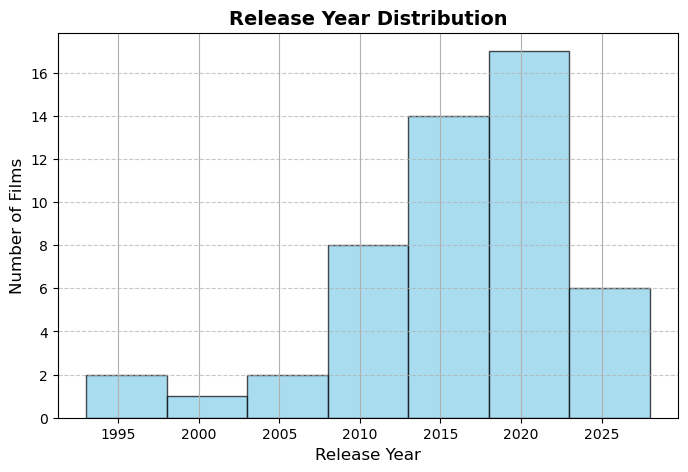

In [11]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(8, 5))

# Create histogram
df['release_year'].hist(
    bins=[y for y in range(df['release_year'].min(), df['release_year'].max() + 5, 5)], 
    color='skyblue', edgecolor='black', alpha=0.7
)

# Titles and labels
plt.title('Release Year Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Films', fontsize=12)

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


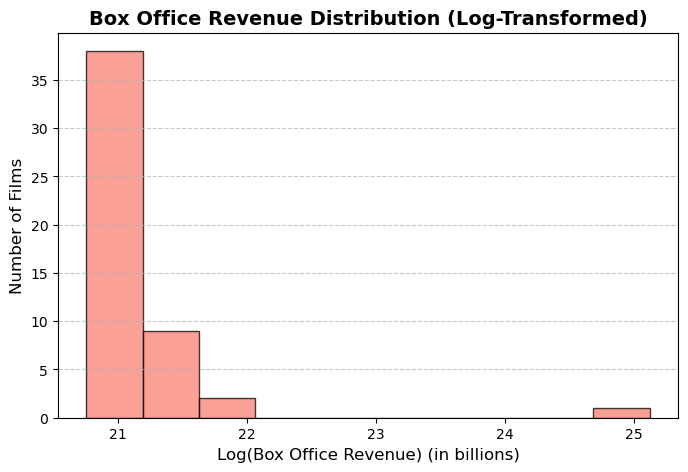

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size
plt.figure(figsize=(8, 5))

# Create histogram
plt.hist(np.log(df['box_office']), color='salmon', edgecolor='black', alpha=0.75)

# Titles and labels
plt.title('Box Office Revenue Distribution (Log-Transformed)', fontsize=14, fontweight='bold')
plt.xlabel('Log(Box Office Revenue) (in billions)', fontsize=12)
plt.ylabel('Number of Films', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

#### **Note**: The data contains a wrongly parsed value for one film. This value is adjusted manually.

In [13]:
df.sort_values(by="box_office", ascending=False).head(2)[["title", "box_office"]]

,title,box_office
26,The Fate of the Furious,81238764765
0,Avatar,2923706026


In [14]:
for row in data:
    if row['title'] == 'The Fate of the Furious':
        row['box_office'] = 1238764765
        print("Fixed the value!")
        break

Fixed the value!


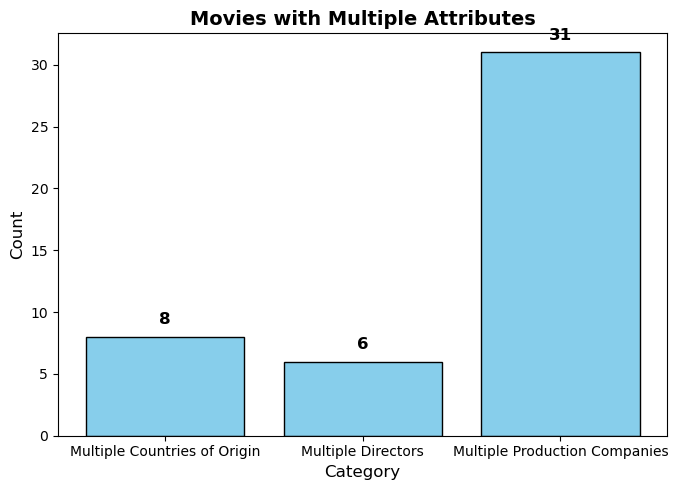

In [15]:
# Data
categories = ['Multiple Countries of Origin', 'Multiple Directors', 'Multiple Production Companies']
counts = [
    len(df[df['countries_of_origin'].apply(len) > 1]),
    len(df[df['directors'].apply(len) > 1]),
    len(df[df['production_companies'].apply(len) > 1])
]

# Create a bar chart
plt.figure(figsize=(7, 5))
plt.bar(categories, counts, color='skyblue', edgecolor='black')

# Titles and labels
plt.title('Movies with Multiple Attributes', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Display values on top of bars
for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', fontsize=12, fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()


### ***Step 6***: Create a database using `sqlite3` and insert the data

In [16]:
import sqlite3

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect("films.db")
cursor = conn.cursor()

# Create table
cursor.execute('''
CREATE TABLE IF NOT EXISTS films (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    title TEXT NOT NULL,
    release_year INTEGER,
    director TEXT,
    box_office INTEGER,
    country TEXT,
    production_companies TEXT
);
''')

# Insert data into table
for film in data:
    cursor.execute(
        """
        INSERT INTO films (title, release_year, director, box_office, country, production_companies)
        VALUES (?, ?, ?, ?, ?, ?)
        """,
        (
            film["title"],
            film.get("release_year"),
            ", ".join(film.get("directors", [])),
            film.get("box_office"),
            ", ".join(film.get("countries_of_origin", [])),
            ", ".join(film.get("production_companies", []))
        )
    )

# Commit and close connection
conn.commit()
conn.close()

In [17]:
conn = sqlite3.connect("films.db")
cursor = conn.cursor()

# Fetch and display data
cursor.execute("SELECT * FROM films")
rows = cursor.fetchall()
for row in rows[:5]:
    print(row)

conn.close()

(1, 'Avatar', 2009, 'James Cameron', 2923706026, 'United Kingdom, United States', '20th Century Fox, Dune Entertainment, Ingenious Film Partners, Lightstorm Entertainment')
(2, 'Avengers: Endgame', 2019, 'Anthony RussoJoe Russo', 2797501328, 'United States', 'Marvel Studios')
(3, 'Avatar: The Way of Water', 2022, 'James Cameron', 2320250281, 'United States', 'TSG Entertainment, Lightstorm Entertainment')
(4, 'Titanic', 1997, 'James Cameron', 2257844554, 'United States', 'Paramount Pictures, 20th Century Fox, Lightstorm Entertainment')
(5, 'Star Wars: The Force Awakens', 2015, 'J. J. Abrams', 2068223624, 'United States', 'Lucasfilm Ltd., Bad Robot')


### **Step 8**: Adjust the JSON fields with respect to requirements:

In [18]:
for film in data:
    for column in ['directors', 'countries_of_origin', 'production_companies']:
        film[column] = ", ".join(film[column])

# Save to a file
with open("films.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)  # Pretty-print with indentation